In [25]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [26]:



import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
import time         


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


from multiprocessing import cpu_count

print("Available CPU cores:", cpu_count())


data = pd.read_csv('flood.csv')
print("Data loaded successfully")


print("\nData shape:", data.shape)
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])


print("\nData types:")
print(data.dtypes)


print("\nFirst 5 rows:")
print(data.head())

  
print("\nLast 5 rows:")
print(data.tail())


print("\nDescriptive statistics:")
print(data.describe())


print("\nDataset info:")
print(data.info())


print(f"\nMemory usage: {data.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")


Available CPU cores: 12
Data loaded successfully

Data shape: (50000, 21)
Number of rows: 50000
Number of columns: 21

Data types:
MonsoonIntensity                     int64
TopographyDrainage                   int64
RiverManagement                      int64
Deforestation                        int64
Urbanization                         int64
ClimateChange                        int64
DamsQuality                          int64
Siltation                            int64
AgriculturalPractices                int64
Encroachments                        int64
IneffectiveDisasterPreparedness      int64
DrainageSystems                      int64
CoastalVulnerability                 int64
Landslides                           int64
Watersheds                           int64
DeterioratingInfrastructure          int64
PopulationScore                      int64
WetlandLoss                          int64
InadequatePlanning                   int64
PoliticalFactors                     int64
FloodProb

In [27]:
# STEP 2: EXPLORE AND UNDERSTAND THE DATA

print("Basic Information:")
print("   Total rows:", data.shape[0])
print("   Total columns:", data.shape[1])


missing_data = data.isnull().sum()
total_missing = missing_data.sum()
print("   Total missing values:", total_missing)

if total_missing > 0:
    print("   Columns with missing data:")
    for col in missing_data[missing_data > 0].index:
        print(f"     {col}: {missing_data[col]} missing")
else:
    print("   No missing data found")


target_column = 'FloodProbability'
print(f"\nTarget Variable: {target_column}")
print(f"   Min: {data[target_column].min():.3f}")
print(f"   Max: {data[target_column].max():.3f}")
print(f"   Mean: {data[target_column].mean():.3f}")

def categorize_risk(probability):
    if probability < 0.35:
        return "Low Risk"
    elif probability < 0.55:
        return "Medium Risk"
    else:
        return "High Risk"

data['Risk_Category'] = data[target_column].apply(categorize_risk)
risk_counts = data['Risk_Category'].value_counts()

print(f"\nRisk Distribution:")
for risk_type, count in risk_counts.items():
    percentage = (count / len(data)) * 100
    print(f"   {risk_type}: {count} samples ({percentage:.1f}%)")


feature_columns = [col for col in data.columns if col not in [target_column, 'Risk_Category']]
print(f"\nFeatures: {len(feature_columns)} total")

print(f"\nExample Feature Statistics:")
for i, col in enumerate(feature_columns[:5]):
    col_data = data[col]
    print(f"   {col}: Range {col_data.min()} to {col_data.max()}, Mean {col_data.mean():.1f}")

print(f"\nStep 2 Complete")

Basic Information:
   Total rows: 50000
   Total columns: 21
   Total missing values: 0
   No missing data found

Target Variable: FloodProbability
   Min: 0.285
   Max: 0.725
   Mean: 0.500

Risk Distribution:
   Medium Risk: 41592 samples (83.2%)
   High Risk: 8373 samples (16.7%)
   Low Risk: 35 samples (0.1%)

Features: 20 total

Example Feature Statistics:
   MonsoonIntensity: Range 0 to 16, Mean 5.0
   TopographyDrainage: Range 0 to 18, Mean 5.0
   RiverManagement: Range 0 to 16, Mean 5.0
   Deforestation: Range 0 to 17, Mean 5.0
   Urbanization: Range 0 to 17, Mean 5.0

Step 2 Complete


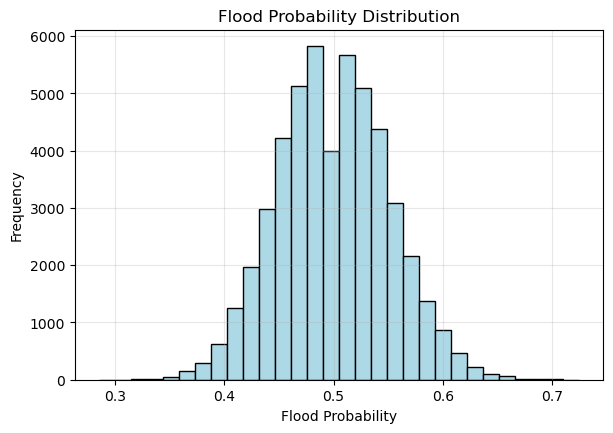

In [28]:
# STEP 3: CREATE SIMPLE VISUALIZATIONS


plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
plt.hist(data['FloodProbability'], bins=30, color='lightblue', edgecolor='black')
plt.title('Flood Probability Distribution')
plt.xlabel('Flood Probability')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)



Text(0.5, 1.0, 'Risk Level Distribution')

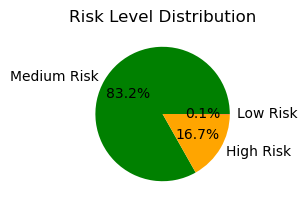

In [29]:

plt.subplot(2, 2, 2)
risk_counts = data['Risk_Category'].value_counts()
colors = ['green', 'orange', 'red']
plt.pie(risk_counts.values, labels=risk_counts.index, colors=colors, autopct='%1.1f%%')
plt.title('Risk Level Distribution')



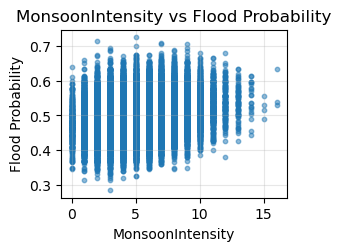

In [30]:

sample_feature = feature_columns[0]
plt.subplot(2, 2, 3)
plt.scatter(data[sample_feature], data['FloodProbability'], alpha=0.5, s=10)
plt.xlabel(sample_feature)
plt.ylabel('Flood Probability')
plt.title(f'{sample_feature} vs Flood Probability')
plt.grid(True, alpha=0.3)



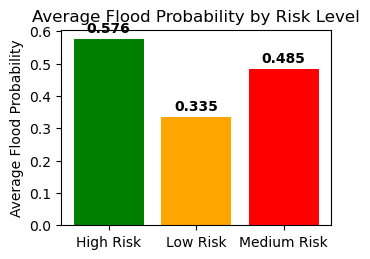

Top 10 Most Important Features:
    1. DeterioratingInfrastructure: 0.229
    2. TopographyDrainage: 0.229
    3. RiverManagement: 0.229
    4. Watersheds: 0.228
    5. DamsQuality: 0.227
    6. PopulationScore: 0.227
    7. Siltation: 0.227
    8. IneffectiveDisasterPreparedness: 0.225
    9. PoliticalFactors: 0.225
   10. MonsoonIntensity: 0.224
Step 3 Complete


In [31]:
# Graph 4: Average Flood Probability by Risk Category
plt.subplot(2, 2, 4)
avg_by_risk = data.groupby('Risk_Category')['FloodProbability'].mean()
colors = ['green', 'orange', 'red']
bars = plt.bar(avg_by_risk.index, avg_by_risk.values, color=colors)
plt.title('Average Flood Probability by Risk Level')
plt.ylabel('Average Flood Probability')

for bar, value in zip(bars, avg_by_risk.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


correlations = {}
for feature in feature_columns:
    correlation = data[feature].corr(data['FloodProbability'])
    correlations[feature] = abs(correlation)

sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Most Important Features:")
for i, (feature, correlation) in enumerate(sorted_features[:10], 1):
    print(f"   {i:2d}. {feature}: {correlation:.3f}")

top_features = [feature for feature, _ in sorted_features[:10]]

print("Step 3 Complete")

In [36]:
# STEP 4: MINIMAL DATA PREPROCESSING

print("Separating features and target")
X = data[feature_columns].copy()
y = data['FloodProbability'].copy()

print("   Features:", X.shape[1], "columns")
print("   Samples:", X.shape[0], "rows")


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print("Splitting data")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("   Training:", X_train.shape[0], "samples")
print("   Testing:", X_test.shape[0], "samples")


Separating features and target
   Features: 20 columns
   Samples: 50000 rows
Splitting data
   Training: 40000 samples
   Testing: 10000 samples


In [37]:
# STEP 5: BUILD MACHINE LEARNING MODELS

print("MODEL 1: XGBOOST")


xgb_normal = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=1  
)

print("Training XGBoost (Normal - 1 CPU core)...")
start_time = time.time()
xgb_normal.fit(X_train, y_train)
xgb_normal_time = time.time() - start_time

print(f"Normal training completed in {xgb_normal_time:.3f} seconds")



MODEL 1: XGBOOST
Training XGBoost (Normal - 1 CPU core)...
Normal training completed in 0.376 seconds


In [38]:
# Create and train XGBoost model (parallel)
xgb_parallel = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  
)

print(f"Training XGBoost (Parallel - {cpu_count()} CPU cores)...")
start_time = time.time()
xgb_parallel.fit(X_train, y_train)
xgb_parallel_time = time.time() - start_time

print(f"Parallel training completed in {xgb_parallel_time:.3f} seconds")



Training XGBoost (Parallel - 12 CPU cores)...
Parallel training completed in 0.142 seconds


In [39]:
# Test XGBoost models
xgb_normal_predictions = xgb_normal.predict(X_test)
xgb_parallel_predictions = xgb_parallel.predict(X_test)


xgb_normal_rmse = np.sqrt(mean_squared_error(y_test, xgb_normal_predictions))
xgb_normal_r2 = r2_score(y_test, xgb_normal_predictions)

xgb_parallel_rmse = np.sqrt(mean_squared_error(y_test, xgb_parallel_predictions))
xgb_parallel_r2 = r2_score(y_test, xgb_parallel_predictions)

print(f"\nXGBoost Results:")
print(f"   Normal (1 core):")
print(f"      RMSE: {xgb_normal_rmse:.4f}")
print(f"      R2 Score: {xgb_normal_r2:.4f}")
print(f"      Training time: {xgb_normal_time:.3f} seconds")

print(f"   Parallel ({cpu_count()} cores):")
print(f"      RMSE: {xgb_parallel_rmse:.4f}")
print(f"      R2 Score: {xgb_parallel_r2:.4f}")
print(f"      Training time: {xgb_parallel_time:.3f} seconds")




XGBoost Results:
   Normal (1 core):
      RMSE: 0.0136
      R2 Score: 0.9252
      Training time: 0.376 seconds
   Parallel (12 cores):
      RMSE: 0.0136
      R2 Score: 0.9252
      Training time: 0.142 seconds


In [40]:
print("\nMODEL 2: RANDOM FOREST")


rf_normal = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=1
)

rf_parallel = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


print("Training Random Forest (Normal - 1 CPU core)...")
start_time = time.time()
rf_normal.fit(X_train, y_train)
rf_normal_time = time.time() - start_time

print(f"Normal training completed in {rf_normal_time:.3f} seconds")




MODEL 2: RANDOM FOREST
Training Random Forest (Normal - 1 CPU core)...
Normal training completed in 25.230 seconds


In [41]:

print(f"Training Random Forest (Parallel - {cpu_count()} CPU cores)...")
start_time = time.time()
rf_parallel.fit(X_train, y_train)
rf_parallel_time = time.time() - start_time

print(f"Parallel training completed in {rf_parallel_time:.3f} seconds")



Training Random Forest (Parallel - 12 CPU cores)...
Parallel training completed in 3.769 seconds


In [42]:

rf_normal_predictions = rf_normal.predict(X_test)
rf_parallel_predictions = rf_parallel.predict(X_test)


rf_normal_rmse = np.sqrt(mean_squared_error(y_test, rf_normal_predictions))
rf_normal_r2 = r2_score(y_test, rf_normal_predictions)

rf_parallel_rmse = np.sqrt(mean_squared_error(y_test, rf_parallel_predictions))
rf_parallel_r2 = r2_score(y_test, rf_parallel_predictions)

print(f"\nRandom Forest Results:")
print(f"   Normal (1 core):")
print(f"      RMSE: {rf_normal_rmse:.4f}")
print(f"      R2 Score: {rf_normal_r2:.4f}")
print(f"      Training time: {rf_normal_time:.3f} seconds")

print(f"   Parallel ({cpu_count()} cores):")
print(f"      RMSE: {rf_parallel_rmse:.4f}")
print(f"      R2 Score: {rf_parallel_r2:.4f}")
print(f"      Training time: {rf_parallel_time:.3f} seconds")




Random Forest Results:
   Normal (1 core):
      RMSE: 0.0259
      R2 Score: 0.7305
      Training time: 25.230 seconds
   Parallel (12 cores):
      RMSE: 0.0259
      R2 Score: 0.7305
      Training time: 3.769 seconds


In [43]:
print(f"\nMODEL COMPARISON:")
models_comparison = [
    ("XGBoost (Normal)", xgb_normal_rmse, xgb_normal_r2, xgb_normal_time),
    ("XGBoost (Parallel)", xgb_parallel_rmse, xgb_parallel_r2, xgb_parallel_time),
    ("Random Forest (Normal)", rf_normal_rmse, rf_normal_r2, rf_normal_time),
    ("Random Forest (Parallel)", rf_parallel_rmse, rf_parallel_r2, rf_parallel_time)
]

for name, rmse, r2, time_taken in models_comparison:
    print(f"{name}:")
    print(f"   RMSE: {rmse:.4f} | R2: {r2:.4f} | Time: {time_taken:.3f}s")


best_model = min(models_comparison, key=lambda x: x[1])
print(f"\nBest Model: {best_model[0]} (lowest RMSE)")


results = {
    'xgboost_normal': {
        'model': xgb_normal,
        'rmse': xgb_normal_rmse,
        'r2': xgb_normal_r2,
        'time': xgb_normal_time,
        'predictions': xgb_normal_predictions
    },
    'xgboost_parallel': {
        'model': xgb_parallel,
        'rmse': xgb_parallel_rmse,
        'r2': xgb_parallel_r2,
        'time': xgb_parallel_time,
        'predictions': xgb_parallel_predictions
    },
    'random_forest_normal': {
        'model': rf_normal,
        'rmse': rf_normal_rmse,
        'r2': rf_normal_r2,
        'time': rf_normal_time,
        'predictions': rf_normal_predictions
    },
    'random_forest_parallel': {
        'model': rf_parallel,
        'rmse': rf_parallel_rmse,
        'r2': rf_parallel_r2,
        'time': rf_parallel_time,
        'predictions': rf_parallel_predictions
    }
}



MODEL COMPARISON:
XGBoost (Normal):
   RMSE: 0.0136 | R2: 0.9252 | Time: 0.376s
XGBoost (Parallel):
   RMSE: 0.0136 | R2: 0.9252 | Time: 0.142s
Random Forest (Normal):
   RMSE: 0.0259 | R2: 0.7305 | Time: 25.230s
Random Forest (Parallel):
   RMSE: 0.0259 | R2: 0.7305 | Time: 3.769s

Best Model: XGBoost (Normal) (lowest RMSE)


In [44]:
# STEP 6: CREATE SIMPLE COMPARISON CHARTS


model_names = ['XGBoost\n(Normal)', 'XGBoost\n(Parallel)', 'Random Forest\n(Normal)', 'Random Forest\n(Parallel)']
rmse_values = [results['xgboost_normal']['rmse'],
               results['xgboost_parallel']['rmse'], 
               results['random_forest_normal']['rmse'], 
               results['random_forest_parallel']['rmse']]
r2_values = [results['xgboost_normal']['r2'],
             results['xgboost_parallel']['r2'],
             results['random_forest_normal']['r2'], 
             results['random_forest_parallel']['r2']]
time_values = [results['xgboost_normal']['time'],
               results['xgboost_parallel']['time'],
               results['random_forest_normal']['time'], 
               results['random_forest_parallel']['time']]



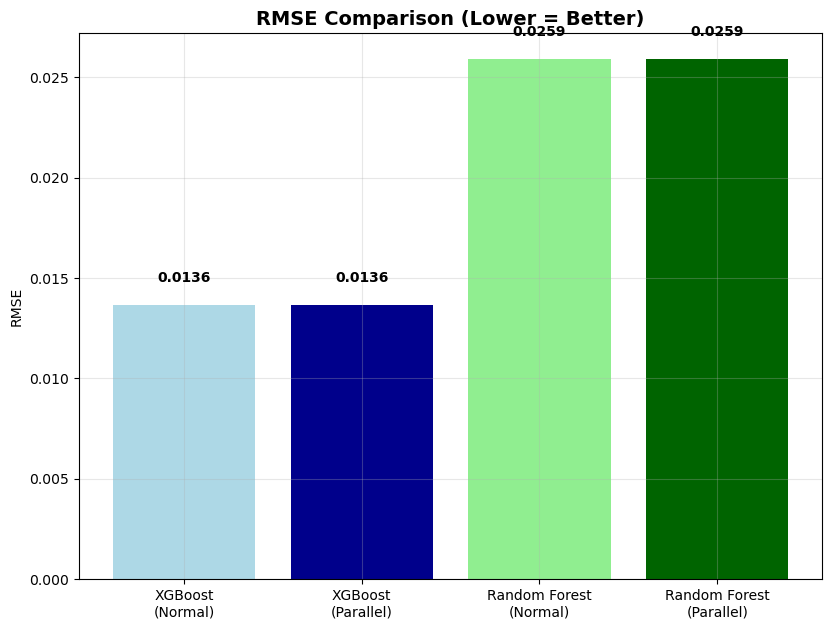

In [52]:

plt.figure(figsize=(16, 12))


plt.subplot(2, 2, 1)
colors = ['lightblue', 'darkblue', 'lightgreen', 'darkgreen']
bars1 = plt.bar(model_names, rmse_values, color=colors)
plt.title('RMSE Comparison (Lower = Better)', fontsize=14, fontweight='bold')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

for bar, value in zip(bars1, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

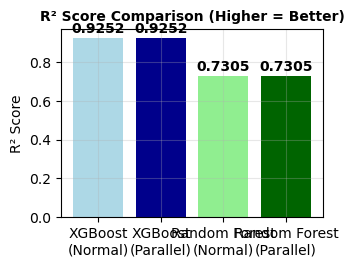

In [53]:

plt.subplot(2, 2, 2)
bars2 = plt.bar(model_names, r2_values, color=colors)
plt.title('R² Score Comparison (Higher = Better)', fontsize=10, fontweight='bold')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)

for bar, value in zip(bars2, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


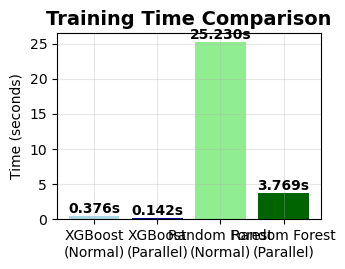

In [50]:
# Chart 3: Training Time Comparison
plt.subplot(2, 2, 3)
bars3 = plt.bar(model_names, time_values, color=colors)
plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3)

for bar, value in zip(bars3, time_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}s', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


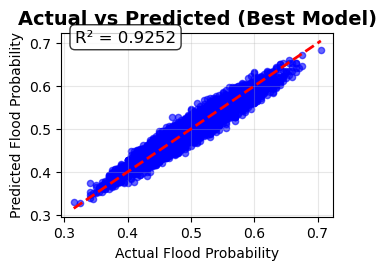

In [48]:
# Chart 4: Actual vs Predicted (best model)
plt.subplot(2, 2, 4)
# Find best model by R² score
best_model_key = max(results.keys(), key=lambda k: results[k]['r2'])
best_predictions = results[best_model_key]['predictions']

plt.scatter(y_test, best_predictions, alpha=0.6, color='blue', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Flood Probability')
plt.ylabel('Predicted Flood Probability')
plt.title('Actual vs Predicted (Best Model)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

best_r2 = results[best_model_key]['r2']
plt.text(0.05, 0.95, f'R² = {best_r2:.4f}', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()



In [54]:
# Model performance summary
print(f"MODEL PERFORMANCE SUMMARY:")
best_rmse = min(rmse_values)
best_r2 = max(r2_values)
fastest_time = min(time_values)

model_list = ['XGBoost (Normal)', 'XGBoost (Parallel)', 'Random Forest (Normal)', 'Random Forest (Parallel)']
for i, name in enumerate(model_list):
    print(f"{name}:")
    print(f"   RMSE: {rmse_values[i]:.4f}")
    print(f"   R²: {r2_values[i]:.4f}")
    print(f"   Time: {time_values[i]:.3f}s")
    print()

print("OVERALL RESULTS:")
best_model_name = model_list[r2_values.index(best_r2)]
print(f"   Best accuracy: {best_model_name}")
print(f"   Both XGBoost and Random Forest benefit from parallel processing")
print(f"   Parallel processing improves training speed")


MODEL PERFORMANCE SUMMARY:
XGBoost (Normal):
   RMSE: 0.0136
   R²: 0.9252
   Time: 0.376s

XGBoost (Parallel):
   RMSE: 0.0136
   R²: 0.9252
   Time: 0.142s

Random Forest (Normal):
   RMSE: 0.0259
   R²: 0.7305
   Time: 25.230s

Random Forest (Parallel):
   RMSE: 0.0259
   R²: 0.7305
   Time: 3.769s

OVERALL RESULTS:
   Best accuracy: XGBoost (Normal)
   Both XGBoost and Random Forest benefit from parallel processing
   Parallel processing improves training speed


In [56]:
# STEP 7: SIMPLE REAL-TIME PREDICTION

# Use best model (find model with highest R² score)
best_model_key = max(results.keys(), key=lambda k: results[k]['r2'])
best_model = results[best_model_key]['model']
print(f"Using best model: {best_model_key.replace('_', ' ').title()}")
print(f"R² Score: {results[best_model_key]['r2']:.4f}")

def simple_flood_prediction(model, scaler, num_predictions=5):
    print(f"\nTesting {num_predictions} different regions:")
    
    np.random.seed(42)
    prediction_results = []
    
    for i in range(num_predictions):
        print(f"\nRegion {i+1}:")
        
        # Create random values for all features
        random_values = {}
        for feature in feature_columns:
            random_values[feature] = np.random.randint(0, 16)
        
        # Convert to model format
        test_data = pd.DataFrame([random_values])
        test_data_scaled = scaler.transform(test_data)
        
        # Make prediction
        start_time = time.time()
        flood_probability = model.predict(test_data_scaled)[0]
        prediction_time = time.time() - start_time
        
        # Determine risk level
        if flood_probability < 0.35:
            risk_level = "LOW RISK"
            action = "Continue normal monitoring"
        elif flood_probability < 0.55:
            risk_level = "MEDIUM RISK"
            action = "Increase monitoring frequency"
        else:
            risk_level = "HIGH RISK"
            action = "Prepare emergency response"
        
        # Show results
        print(f"   Flood Probability: {flood_probability:.3f} ({flood_probability*100:.1f}%)")
        print(f"   Risk Level: {risk_level}")
        print(f"   Prediction Time: {prediction_time*1000:.2f} milliseconds")
        print(f"   Recommended Action: {action}")
        
        # Show top risk factors
        sorted_factors = sorted(random_values.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"   Top Risk Factors:")
        for j, (factor, value) in enumerate(sorted_factors, 1):
            print(f"      {j}. {factor}: {value}")
        
        # Store results
        prediction_results.append({
            'region': i+1,
            'probability': flood_probability,
            'risk_level': risk_level,
            'time_ms': prediction_time * 1000,
            'top_factor': sorted_factors[0][0]
        })
    
    return prediction_results




Using best model: Xgboost Normal
R² Score: 0.9252



Testing 5 different regions:

Region 1:
   Flood Probability: 0.663 (66.3%)
   Risk Level: HIGH RISK
   Prediction Time: 0.00 milliseconds
   Recommended Action: Prepare emergency response
   Top Risk Factors:
      1. Deforestation: 14
      2. RiverManagement: 12
      3. DamsQuality: 12

Region 2:
   Flood Probability: 0.653 (65.3%)
   Risk Level: HIGH RISK
   Prediction Time: 1.53 milliseconds
   Recommended Action: Prepare emergency response
   Top Risk Factors:
      1. AgriculturalPractices: 15
      2. ClimateChange: 13
      3. DeterioratingInfrastructure: 12

Region 3:
   Flood Probability: 0.820 (82.0%)
   Risk Level: HIGH RISK
   Prediction Time: 1.03 milliseconds
   Recommended Action: Prepare emergency response
   Top Risk Factors:
      1. Deforestation: 15
      2. DamsQuality: 15
      3. PopulationScore: 15

Region 4:
   Flood Probability: 0.613 (61.3%)
   Risk Level: HIGH RISK
   Prediction Time: 1.00 milliseconds
   Recommended Action: Prepare emergency response
  

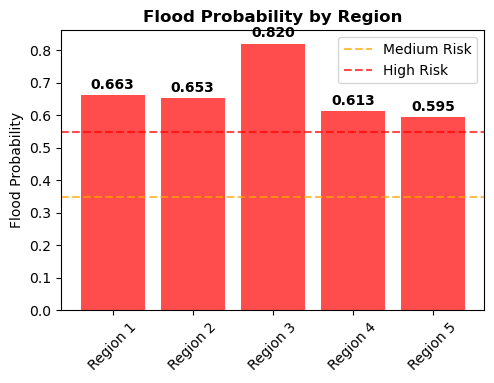

In [57]:
# Test model with new data
predictions = simple_flood_prediction(best_model, scaler, 5)

# Create prediction charts
plt.figure(figsize=(12, 8))

# Chart 1: Flood probabilities by region
plt.subplot(2, 2, 1)
regions = [f"Region {p['region']}" for p in predictions]
probabilities = [p['probability'] for p in predictions]
colors = ['green' if p < 0.35 else 'orange' if p < 0.55 else 'red' for p in probabilities]

bars = plt.bar(regions, probabilities, color=colors, alpha=0.7)
plt.title('Flood Probability by Region', fontweight='bold')
plt.ylabel('Flood Probability')
plt.xticks(rotation=45)

plt.axhline(y=0.35, color='orange', linestyle='--', alpha=0.7, label='Medium Risk')
plt.axhline(y=0.55, color='red', linestyle='--', alpha=0.7, label='High Risk')
plt.legend()

for bar, prob in zip(bars, probabilities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')



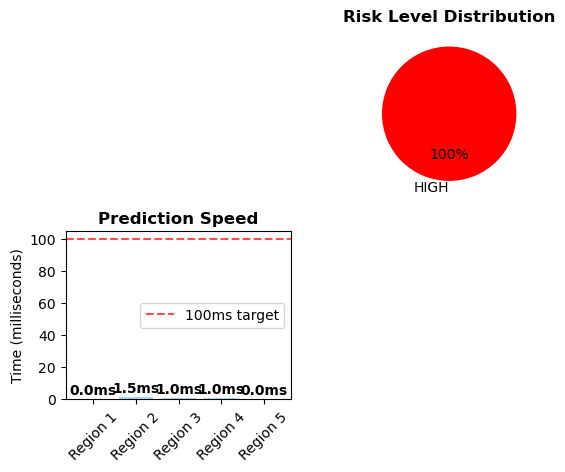

In [58]:
# Chart 2: Risk level distribution
plt.subplot(2, 2, 2)
risk_levels = [p['risk_level'].split()[0] for p in predictions]
risk_counts = {}
for level in risk_levels:
    risk_counts[level] = risk_counts.get(level, 0) + 1

colors_pie = []
for level in risk_counts.keys():
    if level == 'LOW':
        colors_pie.append('green')
    elif level == 'MEDIUM':
        colors_pie.append('orange')
    else:
        colors_pie.append('red')

plt.pie(risk_counts.values(), labels=risk_counts.keys(), colors=colors_pie, 
        autopct='%1.0f%%', startangle=90)
plt.title('Risk Level Distribution', fontweight='bold')

# Chart 3: Prediction speed
plt.subplot(2, 2, 3)
times = [p['time_ms'] for p in predictions]
plt.bar(regions, times, color='skyblue', alpha=0.7)
plt.title('Prediction Speed', fontweight='bold')
plt.ylabel('Time (milliseconds)')
plt.xticks(rotation=45)

plt.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100ms target')
plt.legend()

for i, time_val in enumerate(times):
    plt.text(i, time_val + 1, f'{time_val:.1f}ms', ha='center', va='bottom', fontweight='bold')




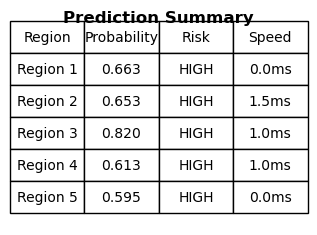

In [59]:
# Chart 4: Summary table
plt.subplot(2, 2, 4)
plt.axis('off')

summary_data = []
for p in predictions:
    summary_data.append([
        f"Region {p['region']}",
        f"{p['probability']:.3f}",
        f"{p['risk_level'].split()[0]}",
        f"{p['time_ms']:.1f}ms"
    ])

table = plt.table(cellText=summary_data,
                 colLabels=['Region', 'Probability', 'Risk', 'Speed'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.title('Prediction Summary', fontweight='bold', y=0.9)

plt.tight_layout()
plt.show()



In [60]:
# System performance summary
print(f"\nSYSTEM PERFORMANCE SUMMARY:")

avg_time = np.mean([p['time_ms'] for p in predictions])
high_risk_count = sum(1 for p in predictions if 'HIGH' in p['risk_level'])
medium_risk_count = sum(1 for p in predictions if 'MEDIUM' in p['risk_level'])
low_risk_count = sum(1 for p in predictions if 'LOW' in p['risk_level'])

print(f"Average prediction time: {avg_time:.2f} milliseconds")
print(f"Real-time capable: {'YES' if avg_time < 100 else 'NO'} (target: <100ms)")
print(f"Regions analyzed: {len(predictions)}")
print(f"Risk distribution:")
print(f"   High risk: {high_risk_count}")
print(f"   Medium risk: {medium_risk_count}")
print(f"   Low risk: {low_risk_count}")

# Emergency response simulation
if high_risk_count > 0:
    print(f"\nEMERGENCY ALERT:")
    print(f"   {high_risk_count} region(s) at HIGH RISK")
    print(f"   Immediate actions needed:")
    print(f"   - Deploy emergency teams")
    print(f"   - Issue evacuation warnings")
    print(f"   - Activate flood barriers")


SYSTEM PERFORMANCE SUMMARY:
Average prediction time: 0.71 milliseconds
Real-time capable: YES (target: <100ms)
Regions analyzed: 5
Risk distribution:
   High risk: 5
   Medium risk: 0
   Low risk: 0

EMERGENCY ALERT:
   5 region(s) at HIGH RISK
   Immediate actions needed:
   - Deploy emergency teams
   - Issue evacuation warnings
   - Activate flood barriers
